In [2]:
import fitsio as fio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p80.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p80.fits')[-1] # Satellite p_mem >= 0.8 catalog

In [4]:
sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
clus_n = len(sat_id_unq)
sat_max = np.amax(counts)

In [5]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    sat_prop_full = sat[prop].read()
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [6]:
# Calculate satellite angular position for all clusters
def sat_ang_pos():
    sat_ra = np.radians(sat_prop('RA'))
    sat_dec = np.radians(sat_prop('DEC'))
    cent_ra = np.radians(cent['RA'].read().reshape(clus_n,-1))
    cent_dec = np.radians(cent['DEC'].read().reshape(clus_n,-1))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [7]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1)/2
    
    return alpha

In [8]:
# Calculate central galaxy alignment angle for all clusters
def cent_gal_ang():
    sat_ang = sat_ang_pos()
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read()).reshape(clus_n,-1)
    delta = sat_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

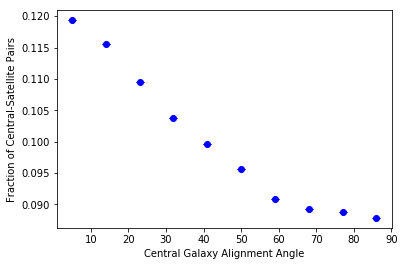

In [9]:
# Flatten central galaxy alignment angle array and plot histogram (with standard error of the mean)
cent_align = cent_gal_ang()
mask = ~np.isnan(cent_align)
cent_align = cent_align[mask]
n, bins = np.histogram(cent_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = cent_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+5., n/len(sat['ID'].read()), yerr=new_array/len(sat['ID'].read()), fmt='bo', capsize=4)
plt.xlabel('Central Galaxy Alignment Angle')
plt.ylabel('Fraction of Central-Satellite Pairs')
plt.show()

In [10]:
np.mean(cent_align)

42.204660272021684

In [12]:
cent_align.shape

(240925,)

In [18]:
np.save('/lsst/troxel/y1a1/lgt20_central_alignment.npy', cent_align)